In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# from IPython.display import HTML

import seaborn as sns
rocket = sns.color_palette("rocket", as_cmap=True)

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150
plt.ioff()

# from tqdm import tqdm
from toric import *

In [3]:
L = 10 # Lattice size
p_error = 0.05 # Error probability per spin
c = 10 # "Field velocity" - number of field updates per cycle
η = 0.25 # Smoothing paramter for Jacobi method
T = 10 # Epochs

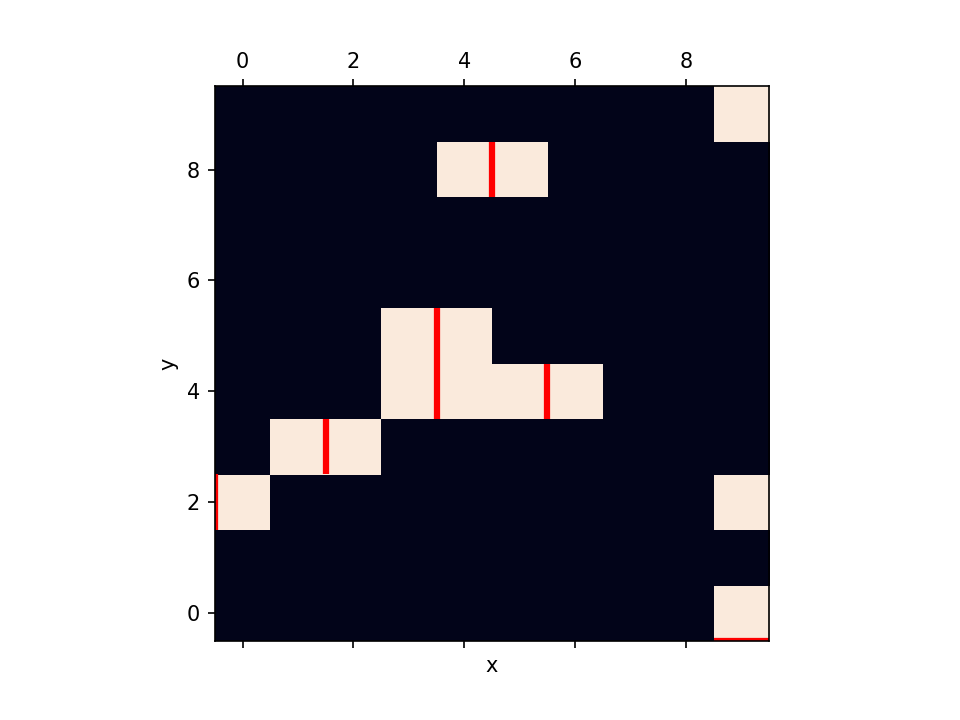

In [4]:
mystate = init_state(L, p_error)
mystate.draw(draw_error = True)
plt.show()

In [6]:
def decoder_2D(state: State, T: int, c: int, η: float) -> tuple[np.ndarray, np.ndarray]:
    """
    Run a 2D decoder on a state for T epochs.

    Parameters:
    state (State): The state to decode.
    T (int): Number of epochs to run.
    c (int): Field velocity.
    η (float): Smoothing parameter.

    Returns:
    np.ndarray: T x L x L array representing the anyon position history.
    """
    q_history = []
    error_history = []
    for _ in range(T):
        for _ in range(c):
            state.update_field(η)
        state.update_anyon
        q_history.append(state.q.copy())
        error_history.append(state.error.copy())
    return np.array(q_history), np.array(error_history)

In [79]:
def plot_evolution(q_history: np.ndarray, trail: bool) -> animation.FuncAnimation:
    """
    Plot the evolution of the anyon position history.

    Parameters:
    q_history (np.ndarray): T x L x L array representing the anyon position history.
    trail (bool): Whether to display a trail behind the anyon as it moves.

    Returns:
    animation.FuncAnimation: Animation of the anyon evolution.
    """

    fig, ax = plt.subplots()
    mat = ax.matshow(q_history[0,:,:], cmap = rocket)
    fig.colorbar(mat)

    def update(i):
        if trail and i > 0:
            previous = q_history[i-1::-1,:,:]
            weights = 2 ** np.arange(-1, -i-1, -1, dtype = np.float32)
            history = np.tensordot(previous, weights, axes = (0, 0))
            mat.set_data(np.maximum(q_history[i,:,:], history))
        else:
            mat.set_data(q_history[i,:,:])
        return mat
    
    return animation.FuncAnimation(fig = fig, func = update, frames = T, interval = 250)

In [80]:
mystate = init_state(L, p_error)
q_history, error_history = decoder_2D(mystate, T, c, η)

# todo:
* figure out how to plot errors

In [81]:
fig, ax = plt.subplots(1, 3)
ax[0].matshow(q_history[-1,:,:], cmap = rocket)
ax[1].matshow(error_history[-1,:,:,0], cmap = rocket)
ax[2].matshow(error_history[-1,:,:,1], cmap = rocket)
ax[0].set_title("Final state anyon configuration")
ax[1].set_title("Final state x errors")
ax[2].set_title("Final state y errors")
# plt.show()

Text(0.5, 1.0, 'Final state y errors')

In [82]:
q_history, error_history = decoder_2D(init_state(L, p_error), T, c, η)

In [83]:
# plot_evolution(q_history, trail = False)

# todo
* fix labelling convention

In [84]:
import numpy as np
import networkx as nx
from pymatching import Matching

def create_block_2D(L,p):

    """
    +-(0,T+1)+--------+--------+--------+
    |        |        |        |        |
    | (0,T)  |        |        |        |
    |        |        |        |        |
    +-(0,T)--+--------+--------+--------+
    |        |        |        |        |
    |        |        |        |        |
    |        |        |        |        |
    +--------+--------+--------+--------+
    |        |        |        |        |
    |        |        |        |        |
    |        |        |        |        |
    +--(0,1)-+--(1,1)-+--------+--------+
    (0,0)  (1,0)      |        |        |
    |  (0,0) |  (1,0) |        |        |
    |        |        |        |        |
    +--(0,0)-+--(1,0)-+--------+--------+
    """

    # check indicies and vertex indicies

    # errors on edges, and anyons at center of the plaquettes

    c = {}
    b = {}
    error_rate = {}

    nC = 0 # cells
    nB = 0 # bonds

    # Initializes a dictionary containing the bonds and the vertices

    for x in range(L):
        for y in range(L):
        
            # bitflip error on horizontal bonds
            b[x,y,'x'] = nB
            error_rate[nB] = p
            nB += 1

            # bitflip error on vertical bonds
            b[x,y,'y'] = nB
            error_rate[nB] = p
            nB += 1
        

    for x in range(L):
        for y in range(L):
            c[x,y] = nC
            nC += 1
            
    return nC, nB, c, b, error_rate


def create_pcm_2D(nC, nB, c, b, final = False):
    
    # bipartite graph between cells and bonds
    # encodes the structure of the lattice

    pcm = np.zeros((nC, nB), dtype=np.int32)

    for x in range(L):
        for y in range(L):
            
            cc = c[x,y]
            
            bb = b[x,y,'x']
            pcm[cc, bb] = 1
            bb = b[x,(y+1)%L,'x']
            pcm[cc, bb] = 1

            bb = b[x,y,'y']
            pcm[cc, bb] = 1
            bb = b[(x+1)%L,y,'y']
            pcm[cc, bb] = 1
                
    return pcm


def build_matching_graph(pcm, error_rate):
    """Function to build a matching graph from a parity check matrix.

    Parameters:
        pcm (2d numpy array): Parity-check matrix.
        p (float): error probability

    Returns:
        A networkx (matching) graph.
    """

    # Vertices are the stabilizers/checks (cells), and the edges are the errors (bonds)
    # Looks like a toroidal lattice

    g = nx.Graph()
    m, _ = pcm.shape
    x = 0
    # bulk = 0
    b = 0
    z = 0
    for col in pcm.T: # Loop through the qubits
        check_indices = [i for i, y in enumerate(col) if y != 0] # y != 0 if the qubit belongs to stabilizer corresponding to that index

        if len(check_indices) == 2:
            p = error_rate[x]
            g.add_edge(check_indices[0], check_indices[1], fault_ids=x, weight=np.log((1-p)/p)) # Each edge is a qubit
            # bulk += 1
        elif len(check_indices) == 1:
            p = error_rate[x]
            g.add_edge(check_indices[0], m+b, fault_ids=x, weight=np.log((1-p)/p))
            # g.add_edge(check_indices[0], m+b, fault_ids=x, weight=0)
            # no edges added
            b += 1
        else:
            # pass
            if len(check_indices) > 0:
                raise ValueError('Each "bit" should be in one or two checks!')
            else:
                z += 1
            
        x += 1

    print(b, z)

    for i in range(m):
        g.nodes[i]['is_boundary'] = False
    for i in range(b):
        g.nodes[m + i]['is_boundary'] = True
        for j in range(i + 1, b):
            g.add_edge(m + i, m + j, fault_ids=set(), weight=0.0) # What is this line?
        
    # print(x, bulk, boundary)
    
    return g



# 2D decoder
nC_2D, nB_2D, c_2D, b_2D, error_rate_2D = create_block_2D(L, p_error)
# final parity check matrix
pcm_2D = create_pcm_2D(nC_2D, nB_2D, c_2D, b_2D, False)
# print(pcm_final.shape)
matching_graph_2D = build_matching_graph(pcm_2D, error_rate_2D)
m_2D = Matching(matching_graph_2D)



# here syndrome will be the anyon configuration, your state.q
# the returned correction is the guess of error, based on the syndrome
# the guess here is an optimization function, the so-called minimal-weight perfect matching
# the decoder will be applied at the end (for the final state of state.q).

# matches the anyons
corr, weight = m_2D.decode(q_history[-1,:,:], return_weight = True)

0 0


In [85]:
sum0 = 0
for y in range(L):
    tmp0 = 0
    for x in range(L):
        tmp0 = tmp0^corr[b_2D[x,y,'x']]^error_history[-1,x,y,0]
    sum0 += tmp0
    
sum1 = 0
for x in range(L):
    tmp1 = 0
    for y in range(L):
        tmp1 = tmp1^corr[b_2D[x,y,'y']]^error_history[-1,x,y,1]
    sum1 += tmp1

# print(sum0, sum1)

logical_failure = (sum0 > 0) or (sum1 > 0)

In [86]:
logical_failure

False